In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from RBM import RBM
from scipy.integrate import simps
from scipy import stats
import h5py

device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

In [2]:
data = np.genfromtxt('../data/data_1d2c_bal_seed14.dat')
data = torch.tensor((data+1)/2, device = device, dtype = dtype)


In [3]:
data.shape

torch.Size([6000, 1000])

In [4]:

lr = 0.01
NGibbs = 100
annSteps = 0
mb_s = 600
num_pcd = 100
Nh = 20
Nv = data.shape[1]
ep_max = 10
w_hat = torch.linspace(0,1,steps=100)
_, S_d, V = torch.svd(data)
V0 = V[:,0]
N = 20000
it_mean = 50

In [5]:
myRBM = RBM(num_visible=Nv,
            num_hidden=Nh,
            device=device,
            lr=lr,
            gibbs_steps=NGibbs,
            UpdCentered=False,
            mb_s=mb_s,
            num_pcd=num_pcd,
            w_hat = w_hat,
            N = N,
            it_mean = it_mean,
            V = V0,
            TMCLearning = True
           )

In [6]:
myRBM.fit(data.T, ep_max)

IT  0


KeyboardInterrupt: 

In [ ]:
%debug

In [6]:
f = h5py.File("../model/AllParametersTMC_NGibbs_100_Nh20_Ns1000_Nmb600_Nepoch100_lr_0.01.h5", 'r')
myRBM.W = torch.tensor(f['W242'], device = myRBM.device)
myRBM.hbias = torch.tensor(f['hbias242'], device = myRBM.device)
myRBM.vbias = torch.tensor(f['vbias242'], device = myRBM.device)

In [23]:
vinit = torch.bernoulli(torch.rand(
        (myRBM.Nv, 1000), device=myRBM.device, dtype=myRBM.dtype))
si, _, _, _ = myRBM.Sampling(vinit, it_mcmc=50)

[]

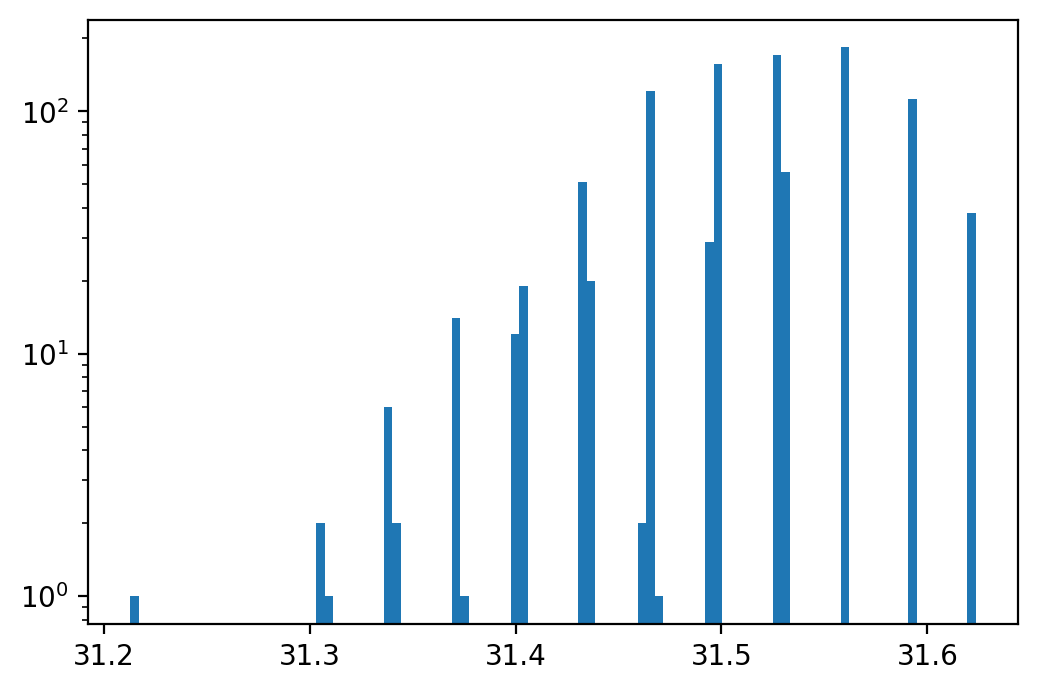

In [24]:
proj_gen = torch.mm(si, V)[:,0]
plt.figure(dpi = 200)
plt.hist(proj_gen.cpu().numpy(), bins = 100);
plt.semilogy()

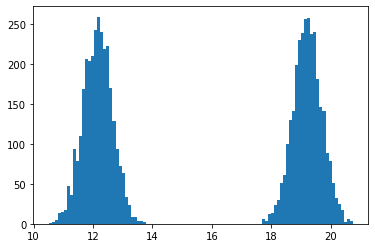

In [16]:
proj_data = torch.mm(data, V)[:,0]
plt.hist(proj_data.cpu().numpy(), bins = 100);

[]

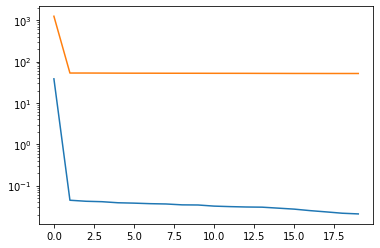

In [17]:
 _, S, _ = torch.svd(myRBM.W)
plt.plot(S.cpu())
plt.plot(S_d.cpu()[:len(S)])
plt.semilogy()

[]

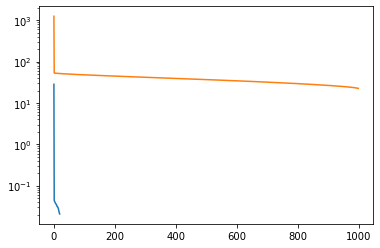

In [11]:
plt.plot(S.cpu())
plt.plot(S_d.cpu())
plt.semilogy()

In [18]:

# Get all registered times
alltimes = []
for t in f['alltime'][:]:
    if 'W'+str(t) in f:
        alltimes.append(t)
print(alltimes)

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 18, 22, 24, 25, 26, 28, 32, 38, 41, 42, 43, 45, 48, 49, 55, 65, 69, 70, 71, 73, 77, 82, 83, 93, 110, 118, 119, 120, 122, 126, 132, 138, 142, 159, 187, 201, 202, 203, 205, 209, 215, 225, 236, 242]


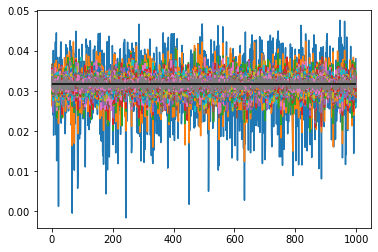

In [19]:
S = torch.zeros(10, len(alltimes), device = device)
for i in range(len(alltimes)):
    t = alltimes[i]
    _, tmpS, tmpV = torch.svd(torch.tensor(f['W'+str(t)], device = device))
    
    plt.plot(tmpV[:,0].cpu(), zorder=0)
    S[:,i] = tmpS[:10]
plt.hlines(1/np.sqrt(1000), 0, 1000, color = 'black', zorder=10)


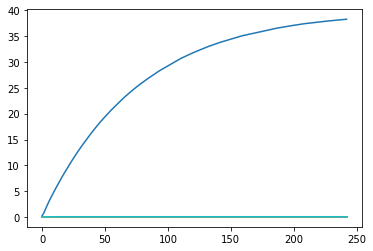

In [20]:
plt.plot(alltimes,S.T.cpu())


In [7]:
nb_chain = 15 # Nb de chaines pour chaque w_hat
it_mcmc = 200 # Nb it_mcmc pour chaque chaine
it_mean = 150 # Nb it considérée pour la moyenne temporelle de chaque chaine
N = 20000 # Contrainte
nb_point = 10000 # Nb de points de discrétisation pour w_hat
xmin = -0.0 
xmax = 1.0

In [8]:
def TMCSample(v, w_hat, N, V,it_mcmc=100,it_mean=50, ß=1):
    vtab = torch.zeros(v.shape, device = device)
    v_curr = v
    V = V
    norm = 1/(v_curr.shape[0]**0.5)
    w_curr = (torch.mv(v_curr.T, V)*norm)
    
    index = torch.randperm(v_curr.shape[0])


    for t in range(it_mcmc):
        #print('init it')
        #print(t)
        h_curr, _ = myRBM.SampleHiddens01(v_curr)
        h_i = (torch.mm(myRBM.W.T, h_curr)+myRBM.vbias.reshape(v.shape[0],1)) # Nv x Ns
        w_next = w_curr.clone()
        
        v_next = torch.clone(v_curr)
        index = torch.randperm(v_curr.shape[0])
        for idx in range(v_curr.shape[0]):
            #print('upd comp')
            i = idx
            v_next[i,:] = 1-v_curr[i,:]
            w_next += ((2*v_next[i,:]-1)*V[i]*norm)

            # On calcul -DeltaE
            ΔE = ß*((2*v_next[i,:]-1)*h_i[i,:])-(N/2)*((w_hat-w_next)**2-(w_hat-w_curr)**2)

            tir = torch.rand(v_curr.shape[1],1, device = torch.device("cuda")).squeeze()
            prob = torch.exp(ΔE).squeeze()
            v_curr[i,:] = torch.where(tir<prob, v_next[i,:], v_curr[i,:])
            v_next[i,:] = torch.where(tir<prob, v_next[i,:], 1-v_next[i,:])
            w_curr = torch.where(tir<prob, w_next, w_curr)
            w_next = torch.where(tir<prob, w_next, w_curr)
            #print(time.time()-s)
        if (t>= (it_mcmc-it_mean)):
            vtab += v_curr

    vtab = vtab*(1/it_mean)    
    return v_curr, h_curr, vtab

In [9]:
start = torch.bernoulli(torch.rand(myRBM.Nv, nb_chain*nb_point, device = device))
#V0 = V[:,0]
# w_hat = torch.dot(start.T, V)[0:,]
w_hat_b = torch.linspace(xmin, xmax, steps =nb_point, device = device)
w_hat = torch.zeros(nb_chain*nb_point, device = device)
for i in range(nb_point):
    for j in range(nb_chain):
        w_hat[i*nb_chain+j] = w_hat_b[i]
tmpv, tmph, vtab = TMCSample(start, w_hat, N, V0, it_mcmc = it_mcmc, it_mean=it_mean)

y = np.array(torch.mm(vtab.T, V0.unsqueeze(1)).cpu().squeeze())/myRBM.Nv**0.5
newy = np.array([np.mean(y[i*nb_chain:i*nb_chain+nb_chain]) for i in range(nb_point)])
w_hat = w_hat.cpu().numpy()
w_hat_b = w_hat_b.cpu().numpy()


In [11]:
res=np.zeros(len(w_hat_b)-1)
for i in range(1,len(w_hat_b)):
    res[i-1] = simps(newy[:i]-w_hat_b[:i], w_hat_b[:i])


In [21]:
const = simps(np.exp(N*res-np.max(N*res)), w_hat_b[:-1])
p_m = np.exp(N*res-np.max(N*res))/const

In [22]:
print(simps(p_m, w_hat_b[:-1]))
potential = res + (1/N)*np.log(const)

0.9999999999999999


<ipython-input-24-c7f51a8dc6b6>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_data =torch.mm(torch.tensor(data, device = device, dtype = dtype), V).cpu()/myRBM.Nv**0.5


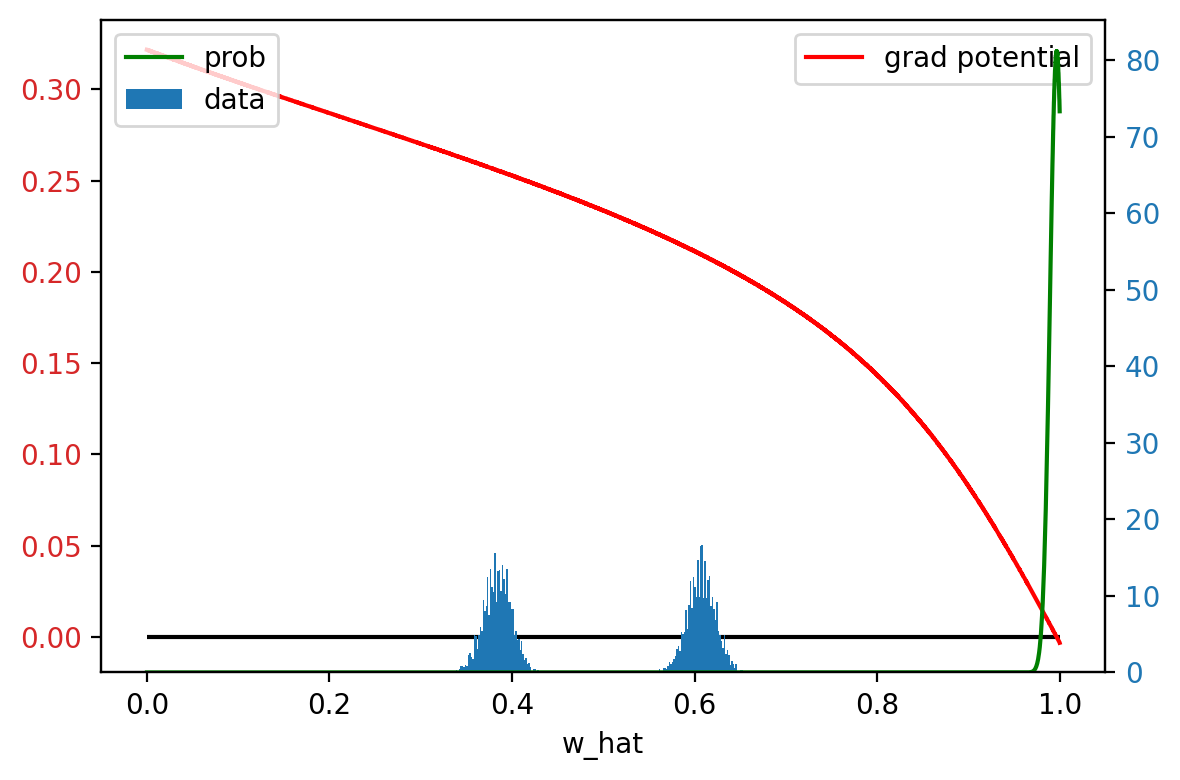

In [24]:
proj_data =torch.mm(torch.tensor(data, device = device, dtype = dtype), V).cpu()/myRBM.Nv**0.5
fig, ax1 = plt.subplots(dpi = 200)

color = 'tab:red'
ax1.set_xlabel("w_hat")
ax1.plot(w_hat_b,newy-w_hat_b,color='red', label = "grad potential")
ax1.hlines(0,0,1, color = 'black')
#ax1.scatter(proj_gen[:,0], proj_gen[:,1],alpha=0.2, label = 'data_gen')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
rdm_y = torch.randn(proj_data[:,0].shape)/20
ax2.hist(proj_data[:,0].numpy(), label = 'data', density=True, bins=200)
ax2.plot(w_hat_b[1:], p_m, color = "green", label = "prob")

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend()
ax2.legend()
plt.show()